# Hair segmentation (part 1 of hairstyle swap)

## Set up Google Colab 

In [1]:
%ls

bdrive/  sample_data/


In [0]:
from google.colab import drive 
drive.mount("bdrive")

In [2]:
cd bdrive/My\ Drive/app/Hair-segmentation/

/content/bdrive/My Drive/app/Hair-segmentation


### Install packages

In [5]:
!pip install -U cython
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git

Requirement already up-to-date: cython in /usr/local/lib/python3.6/dist-packages (0.29.2)
  Cloning https://github.com/lucasb-eyer/pydensecrf.git to /tmp/pip-req-build-6ql3fwtm
  Running setup.py bdist_wheel for pydensecrf ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /tmp/pip-ephem-wheel-cache-ius4l364/wheels/81/ac/ed/09f1890b954ca1ff7f189518cc9a319138e50e7ea88937fae9
Successfully built pydensecrf


In [3]:
!pip uninstall keras
!pip install keras==2.1.4


## Imports

In [4]:
import keras 

import numpy as np
import matplotlib.pyplot as plt 
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import scipy.misc

print(keras.__version__)

from keras import Input
from keras.applications.mobilenet import DepthwiseConv2D, relu6
from keras.layers import BatchNormalization, Activation, Conv2D, concatenate, Conv2DTranspose
from layers import BilinearUpSampling2D
from keras.engine import Model

from keras import backend as K
from keras import callbacks, optimizers
from keras.models import load_model
from keras.utils import CustomObjectScope

import warnings
warnings.filterwarnings("ignore")

import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels

from skimage import data
from scipy import ndimage
import cv2
import scipy.spatial



Using TensorFlow backend.


2.1.4


## Prepare dataset

In [0]:
def normalize(image, mean=None, std=None):
  if mean is None:
    mean = [[[29.24429131, 29.24429131, 29.24429131]]]
  if std is None:
    std = [[[69.8833313, 63.37436676, 61.38568878]]]
  x = (image - np.array(mean)) / (np.array(std) + 1e-7)
  return x

def create_datagen(images, labels, img_generator, lbl_generator, seed):
  img_iter = img_generator.flow(images, seed=seed)
  lbl_iter = lbl_generator.flow(labels, seed=seed)
  
  def datagen():
    while True:
      img = img_iter.next()
      lbl = lbl_iter.next()
      yield img, lbl
      
  return datagen

def load_data(img_file, mask_file):
  seed = 1
  images = np.load(img_file)
  labels = np.load(mask_file)
  
  x_train, x_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=seed)
  
  train_img_gen = ImageDataGenerator(featurewise_center = True,
                                     featurewise_std_normalization=True,
                                     rotation_range= 20,
                                     shear_range= 0.2, 
                                     zoom_range= 0.2,
                                     horizontal_flip = True)
  train_img_gen.fit(images)
  
  train_lab_gen = ImageDataGenerator(rescale =1./255,
                                     rotation_range=20,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip = True)
  
  train_gen = create_datagen(x_train, y_train, train_img_gen, train_lab_gen, seed)
  
  valid_img_gen = ImageDataGenerator(featurewise_center = True,
                                     featurewise_std_normalization = True,
                                     horizontal_flip = True)
  
  valid_img_gen.fit(images)
  
  valid_lab_gen = ImageDataGenerator(rescale=1./255,
                                     horizontal_flip = True)
  
  valid_gen = create_datagen(x_val, y_val, valid_img_gen, valid_lab_gen, seed)
  
  return train_gen, valid_gen, images.shape[1:3]

## Model

### Define architecture

In [0]:
def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1), block_id=1):
  channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
  filters = int(filters * alpha)
  
  x = Conv2D(filters, kernel, padding='same', use_bias=False, strides=strides, name='conv_%d' % block_id)(inputs)
  x = BatchNormalization(axis=channel_axis, name='conv_%d_bn' % block_id)(x)
  return Activation(relu6, name='conv_%d_relu' % block_id)(x)

def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha, depth_multiplier=1, strides=(1, 1), block_id=1):
  channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
  pointwise_conv_filters = int(pointwise_conv_filters * alpha)
  
  x = DepthwiseConv2D((3, 3),
                      padding='same',
                      depth_multiplier=depth_multiplier,
                      strides=strides,
                      use_bias=False,
                      name='conv_dw_%d' % block_id)(inputs)
  
  x = BatchNormalization(axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
  x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)
  
  x = Conv2D(pointwise_conv_filters, (1, 1), padding='same', use_bias=False, strides=(1, 1), name='conv_pw_%d' % block_id)(x)
  x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)
  return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)

def MobileUNet(input_shape=None, alpha=1.0, alpha_up=1.0, depth_multiplier=1, dropout=1e-3, input_tensor=None):
  if input_tensor is None:
    img_input = Input(shape=input_shape)
  else:
    if not K.is_keras_tensor(input_tensor):
      img_input = Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor
      
  b00 = _conv_block(img_input, 32, alpha, strides=(2, 2), block_id=0)
  
  b01 = _depthwise_conv_block(b00, 64, alpha, depth_multiplier, block_id=1)
  b02 = _depthwise_conv_block(b01, 128, alpha, depth_multiplier, block_id=2, strides=(2, 2))
  b03 = _depthwise_conv_block(b02, 128, alpha, depth_multiplier, block_id=3)
  b04 = _depthwise_conv_block(b03, 256, alpha, depth_multiplier, block_id=4, strides=(2, 2))
  b05 = _depthwise_conv_block(b04, 256, alpha, depth_multiplier, block_id=5)
  b06 = _depthwise_conv_block(b05, 512, alpha, depth_multiplier, block_id=6, strides=(2, 2))
  b07 = _depthwise_conv_block(b06, 512, alpha, depth_multiplier, block_id=7)
  b08 = _depthwise_conv_block(b07, 512, alpha, depth_multiplier, block_id=8)
  b09 = _depthwise_conv_block(b08, 512, alpha, depth_multiplier, block_id=9)
  b10 = _depthwise_conv_block(b09, 512, alpha, depth_multiplier, block_id=10)
  b11 = _depthwise_conv_block(b10, 512, alpha, depth_multiplier, block_id=11)
  b12 = _depthwise_conv_block(b11, 1024, alpha, depth_multiplier, block_id=12, strides=(2, 2))
  b13 = _depthwise_conv_block(b12, 1024, alpha, depth_multiplier, block_id=13)
  
  filters = int(512 * alpha)
  up1 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b13), b11], axis=3)
  b14 = _depthwise_conv_block(up1, filters, alpha_up, depth_multiplier, block_id=14)
  
  filters = int(256 * alpha)
  up2 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b14), b05], axis=3)
  b15 = _depthwise_conv_block(up2, filters, alpha_up, depth_multiplier, block_id=15)
  
  
  filters = int(128 * alpha)
  up3 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b15), b03], axis=3)
  b16 = _depthwise_conv_block(up3, filters, alpha_up, depth_multiplier, block_id=16)
  
  filters = int(64 * alpha)
  up4 = concatenate([Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(b16), b01], axis=3)
  b17 = _depthwise_conv_block(up4, filters, alpha_up, depth_multiplier, block_id=17)
  
  filters = int(32 * alpha)
  up5 = concatenate([b17, b00], axis=3)
  b18 = _conv_block(up5, filters, alpha_up, block_id=18)
  
  x = Conv2D(3, (1, 1), kernel_initializer='he_normal', activation='linear')(b18)
  x = BilinearUpSampling2D(size=(2, 2))(x)
  x = Activation('sigmoid')(x)
  
  model = Model(img_input, x)
  return model

### Define loss 

In [0]:
def DICE_coef_loss(pred, truth, smooth = 1e-5):
  pred_f = K.flatten(pred)
  truth_f = K.flatten(truth)
  intersection = K.sum(truth_f * pred_f)
  
  return 1-((2. * intersection + smooth) / (K.sum(truth_f) + K.sum(pred_f) + smooth))

### Define Scheduler

In [0]:
def create_lr_schedule(epochs):
  return lambda epoch: _lr_schedule(epoch, epochs)

def _lr_schedule(epoch, epochs):
  if epoch > 0.9 * epochs: lr = 0.0001
  elif epoch > 0.75 * epochs: lr = 0.001
  elif epoch > 0.5 * epochs: lr = 0.01
  else: lr = 0.1
    
  return lr

### Train model

In [0]:
def train(train_gen, val_gen, model, epochs=250, batch_size=16):
  
  model.compile(optimizer = optimizers.SGD(lr=0.0001, momentum=0.9),
                loss = DICE_coef_loss)
  
  scheduler = callbacks.LearningRateScheduler(create_lr_schedule(epochs))
  checkpoint = callbacks.ModelCheckpoint(filepath="unet-keras-model-weights2.hd5",
                                         save_weights_only= True,
                                         save_best_only = True)
  
  model.fit_generator(generator=train_gen(),
                      steps_per_epoch = 2341 // batch_size,
                      epochs = epochs,
                      validation_data = val_gen(),
                      validation_steps = 586 // batch_size,
                      callbacks=[scheduler, checkpoint])
  
  model.save("unet-keras-model2.h5")

In [0]:
train_gen, val_gen, img_shape = load_data("data/LFW-keras/images-192.npy", "data/LFW-keras/masks-192.npy")
model =  MobileUNet(input_shape=(img_shape[0], img_shape[1], 3), alpha=1, alpha_up=0.25)

In [0]:

#train(train_gen, val_gen, model)

###  Evaluate model

In [50]:
def color2classes(img):
  new_img = np.zeros((192, 192)).astype(np.uint8)
  for i in range(192):
    for j in range(192):
      if img[i, j, 2] == 255:
        new_img[i, j] = 0
      elif img[i, j, 1] == 255:
        new_img[i, j] = 1
      else:
        new_img[i, j] = 2
  return new_img

def iou(y_hat, y):
  ious = []
  for c in range(3):
    pred_inds = y_hat == c
    target_inds = y == c
    intersection = pred_inds[target_inds].sum()
    union = pred_inds.sum() + target_inds.sum() - intersection
    if union == 0:
      ious.append(float('nan')) # If there is no ground truth, do not include in evaluation
    else:
      ious.append(float(intersection) / max(union, 1))
  return ious

def pixel_accuracy(y_hat, y):
  correct = (y_hat == y).sum()
  total = (y == y).sum()
  return correct/total

def custom_objects():
  return {'relu6': relu6,
          'DepthwiseConv2D': DepthwiseConv2D,
          'BilinearUpSampling2D': BilinearUpSampling2D,
          'dice_coef_loss': DICE_coef_loss
         }

SAVED_MODEL = 'unet-keras-model2.h5'
SAVED_WEIGHTS = 'unet-keras-model-weights2.hd5'

with CustomObjectScope(custom_objects()):
  model = load_model(SAVED_MODEL)
  model.load_weights(SAVED_WEIGHTS)

images = np.load('data/LFW-keras/images-192.npy')
masks = np.load('data/LFW-keras/masks-192.npy')
total_ious = [] 
pixel_accs = []

_, images, _, labels = train_test_split(images, masks, test_size=0.2, random_state=2)

for img, mask in zip(images, labels):
  inp = img.reshape(1, 192, 192, 3).astype(float)
  
  prob_pred = model.predict(normalize(inp)).reshape(192, 192, 3)
  pred = np.uint8((prob_pred.round())*255)
  
  new_mask = color2classes(mask)
  new_pred = color2classes(pred)
  
  total_ious.append(iou(new_pred, new_mask))
  pixel_accs.append(pixel_accuracy(new_pred, new_mask))

# Mean IoU
total_ious = np.array(total_ious).T
mean_iou = np.nanmean(np.nanmean(total_ious, axis=1))

# Pixel accuracy
pixel_acc = np.array(pixel_accs).mean()


print("IoU: ", mean_iou, " Pixel accuracy: ", pixel_acc)  

IoU:  0.8683368573337037  Pixel accuracy:  0.9682120018309157


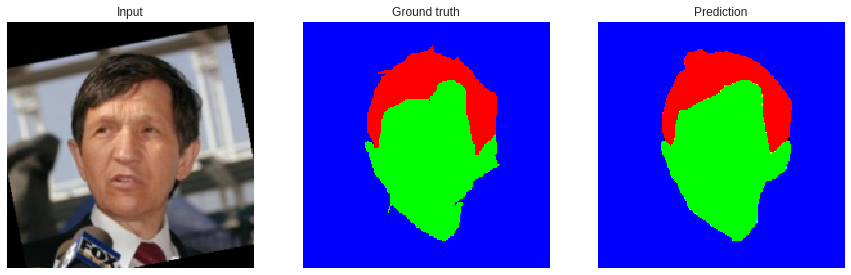

In [53]:
plot_imgs([img, mask, pred], ["Input", "Ground truth", "Prediction"], (15, 15))

### Save model

In [0]:
#model.save("unet-keras-model2.h5")

### Inference 

In [0]:
def custom_objects():
  return {'relu6': relu6,
          'DepthwiseConv2D': DepthwiseConv2D,
          'BilinearUpSampling2D': BilinearUpSampling2D,
          'dice_coef_loss': DICE_coef_loss
         }

def plot_imgs(images = [], titles = [], figsize = (10,10)):
  size = len(images)
  fig = plt.figure(figsize=figsize)
  i = 1
  for image in images:
    ax = fig.add_subplot(1,size,i)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[i-1])
    ax.imshow(image)
    i += 1
  return None

In [0]:
SAVED_MODEL = 'unet-keras-model2.h5'
SAVED_WEIGHTS = 'unet-keras-model-weights2.hd5'

with CustomObjectScope(custom_objects()):
  model = load_model(SAVED_MODEL)
  model.load_weights(SAVED_WEIGHTS)

images = np.load('data/LFW-keras/images-192.npy')
masks = np.load('data/LFW-keras/masks-192.npy')

In [0]:
test_path = "./images/test2.jpg"
id_img = 47


original = images[id_img]
image = images[id_img].reshape(1, 192, 192, 3).astype(float)
label = masks[id_img]

prob_pred = model.predict(normalize(image)).reshape(192, 192, 3)
pred = np.uint8((prob_pred.round())*255)


test_original = scipy.misc.imread(test_path, mode="RGB")
test_original_r = scipy.misc.imresize(test_original, (192, 192))
h, w, _ = test_original.shape

test_input = test_original_r.reshape(1, 192, 192, 3).astype(float)

test_probs_pred = model.predict(normalize(test_input)).reshape(192, 192, 3)
test_pred = np.uint8((test_probs_pred.round())*255)
test_pred_r = scipy.misc.imresize(test_pred, (h, w)) 

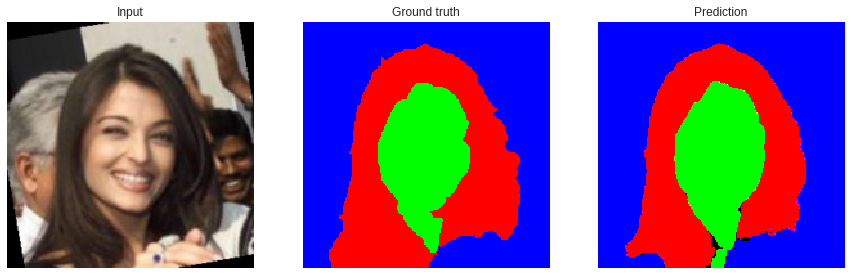

In [0]:
plot_imgs([original, label, pred], ["Input", "Ground truth", "Prediction"], (15, 15))

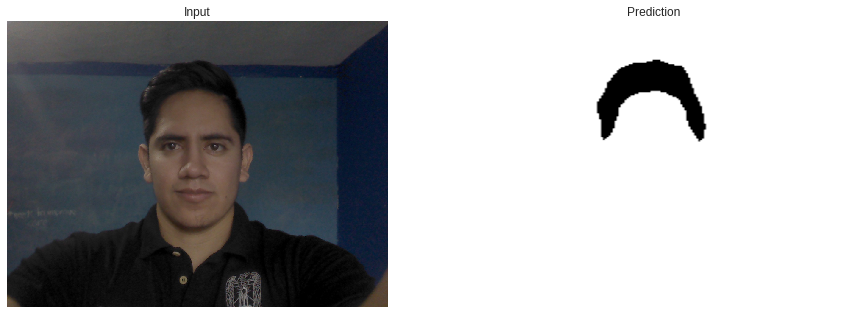

In [0]:
plot_imgs([test_original, test_pred_r[:,:,0]], ["Input", "Prediction"], (15, 15))

## Fully connected CRF 

In [0]:
def CRF(original, prediction, c, iteractions=5, gsxy=(3, 3), gcomp= 3, bsxy=(80,80), bcomp=10, srgb=(13, 13, 13)):
  prediction = prediction[:,:,c] + (prediction[:,:,0]<<8) + (prediction[:,:,2]<<16)
  
  colors, labels = np.unique(prediction, return_inverse=True)
  
  colorize = np.empty((len(colors), 3), np.uint8)
  
  colorize[:,0] = (colors & 0x0000FF)
  colorize[:,1] = (colors & 0x00FF00) >> 8
  colorize[:,2] = (colors & 0xFF0000) >> 16
  
  n_labels = len(set(labels.flat))
  
  d = dcrf.DenseCRF2D(original.shape[1], original[3].shape[0], n_labels)
  U = unary_from_labels(labels, n_labels, gt_prob=0.9, zero_unsure=False)
  d.setUnaryEnergy(U)
  d.addPairwiseGaussian(sxy=gsxy, compat=gcomp, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
  d.addPairwiseBilateral(sxy=bsxy, srgb=srgb, rgbim=original,
                       compat=bcomp,
                       kernel=dcrf.DIAG_KERNEL,
                       normalization=dcrf.NORMALIZE_SYMMETRIC)
  
  Q = d.inference(iteractions)
  
  output = np.argmax(Q, axis=0)
  output = colorize[output,:]
  output = output.reshape(192, 192, 3)
  return output 

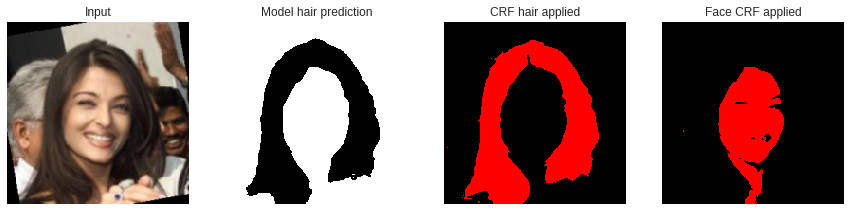

In [0]:
crf_hair_image = CRF(original, pred, 0, 1)
crf_face_image = CRF(original, pred, 1, 1)

plot_imgs([original, pred[:,:,0], crf_hair_image, crf_face_image], ["Input",  "Model hair prediction", "CRF hair applied", "Face CRF applied" ], (15, 15))

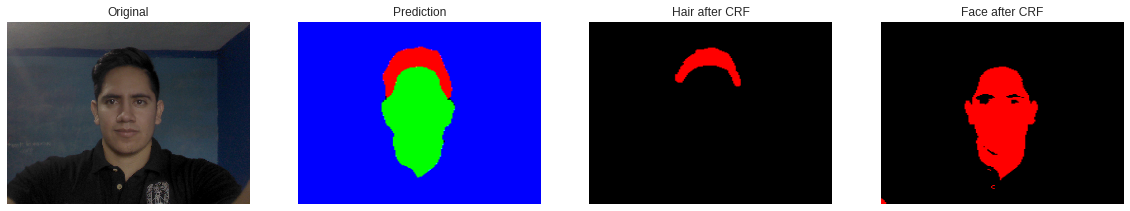

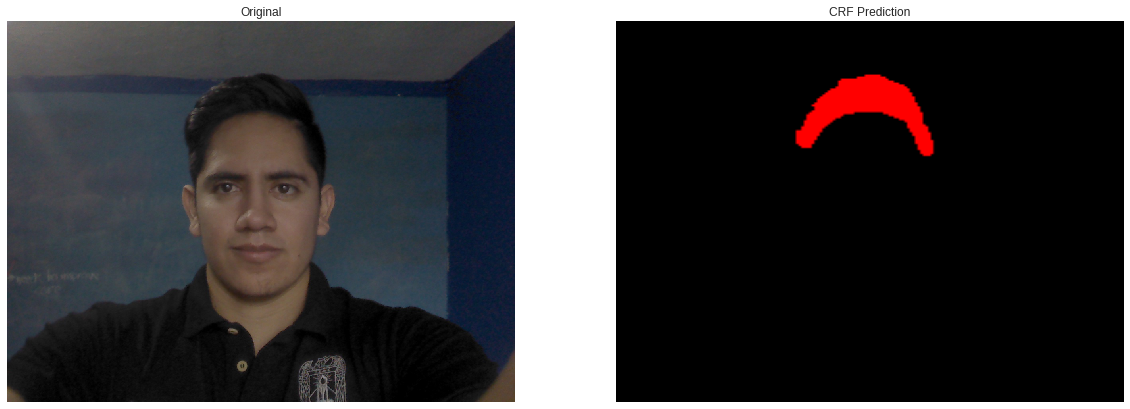

In [0]:
crf_test_hair = CRF(test_original_r, test_pred, 0, 14, (2,2), 15, (50, 50), 10)
crf_test_face = CRF(test_original_r, test_pred, 1, 5)

crf_test_hair = scipy.misc.imresize(crf_test_hair, (h, w))
crf_test_face = scipy.misc.imresize(crf_test_face, (h, w))

plot_imgs([test_original, test_pred_r, crf_test_hair, crf_test_face], ["Original", "Prediction", "Hair after CRF", "Face after CRF" ], (20, 20))
plot_imgs([test_original, crf_test_hair], ["Original", "CRF Prediction"], (20, 20))

## Image matting

### Generate trimaps

In [0]:
def get_trimap(img, size=5, number=1):
  pixels = 2*size + 1
  kernel = np.ones((pixels,pixels),np.uint8)
  dilation = cv2.dilate(img, kernel, iterations = 1) 
  
  dilation = np.where(dilation == 255, 127, dilation) 		
  remake = np.where(dilation != 127, 0, dilation)		
  remake = np.where(img > 127, 200, dilation)			
  
  remake = np.where(remake < 127, 0, remake)		
  remake = np.where(remake > 200, 0, remake)			
  remake = np.where(remake == 200, 255, remake)	
  
  return remake

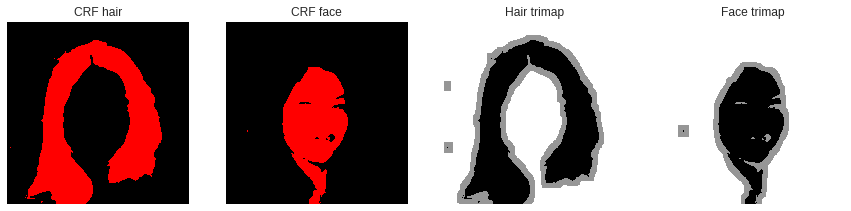

In [0]:
hair_trimap = get_trimap(crf_hair_image)[:,:,0]
face_trimap = get_trimap(crf_face_image)[:,:,0]

plot_imgs([crf_hair_image, crf_face_image, hair_trimap, face_trimap], ["CRF hair",  "CRF face", "Hair trimap", "Face trimap" ], (15, 15))

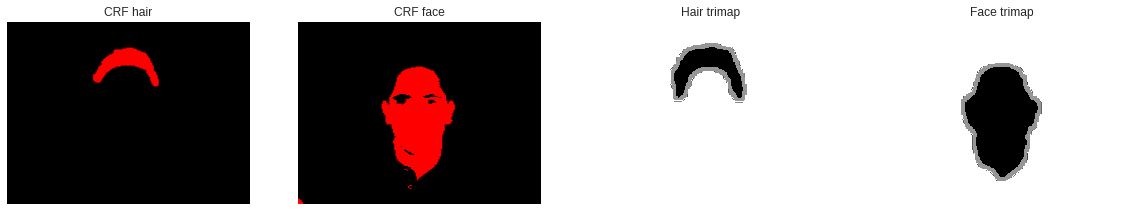

In [0]:
#test_hair_trimap = get_trimap(crf_test_hair, size=30)[:,:,0]
#test_face_trimap = get_trimap(crf_test_face, size=30)[:,:,0]

test_hair_trimap = get_trimap(test_pred_r[:,:,0], size=20)
test_face_trimap = get_trimap(test_pred_r[:,:,1], size=20)

plot_imgs([crf_test_hair, crf_test_face, test_hair_trimap, test_face_trimap], ["CRF hair",  "CRF face", "Hair trimap", "Face trimap" ], (20, 20))

### build alpha mask

In [0]:
import scipy.spatial
import numpy as np

def convex_hull_distance(cvx_hull, pixels):
    d_hull = np.ones(pixels.shape[0]*cvx_hull.equations.shape[0]).reshape(pixels.shape[0],cvx_hull.equations.shape[0])*1000
    for j, surface_eq in enumerate(cvx_hull.equations):
        for i, px_val in enumerate(pixels):
            nhat= surface_eq[:3]
            d_hull[i,j] = np.dot(nhat, px_val) + surface_eq[3]
    return  np.maximum(np.amax(d_hull, axis=1),0)
  
  
def matting(original, trimap, shape):
  
  bg = trimap == 0
  fg = trimap == 255
  unknown = True ^ np.logical_or(fg, bg)
  
  fg_px = original[fg]
  bg_px = original[bg]
  unknown_px = original[unknown]
  
  fg_hull = scipy.spatial.ConvexHull(fg_px)
  fg_vertices_px = fg_px[fg_hull.vertices]
  bg_hull = scipy.spatial.ConvexHull(bg_px)
  bg_vertices_px = bg_px[bg_hull.vertices]
  
  d_fg = convex_hull_distance(fg_hull, unknown_px)
  d_bg = convex_hull_distance(bg_hull, unknown_px)
  
  d_bg1 = np.maximum(np.amax(d_bg),0)
  d_fg1 = np.maximum(np.amax(d_fg),0)
  alpha = d_bg/(d_bg1+d_fg1)
  
  unknown = unknown.astype(float).copy()
  unknown[unknown !=0] = alpha
  mask = unknown + fg
  
  segmented = ((unknown+fg).reshape(shape[0], shape[1], 1).repeat(3,2)*original).astype(np.uint8)
 
  return mask, segmented

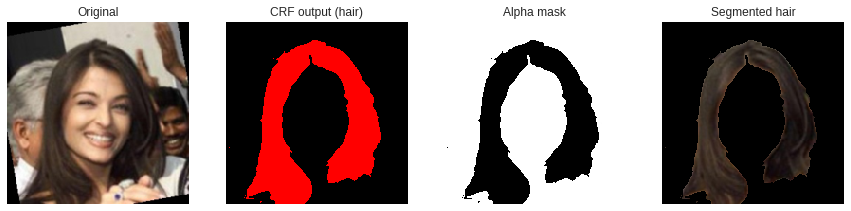

In [0]:
hair_mask_ds, segmented_hair_ds = matting(original, hair_trimap, original.shape)
face_mask_ds, segmented_face_ds = matting(original, hair_trimap, original.shape)

plot_imgs([original, crf_hair_image ,hair_mask_ds, segmented_hair_ds], ["Original",  "CRF output (hair)", "Alpha mask", "Segmented hair"], (15, 15))

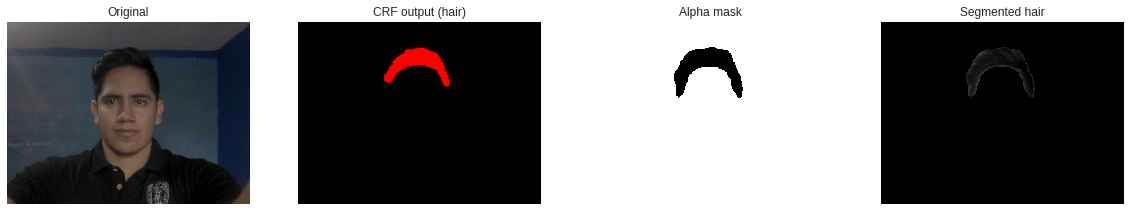

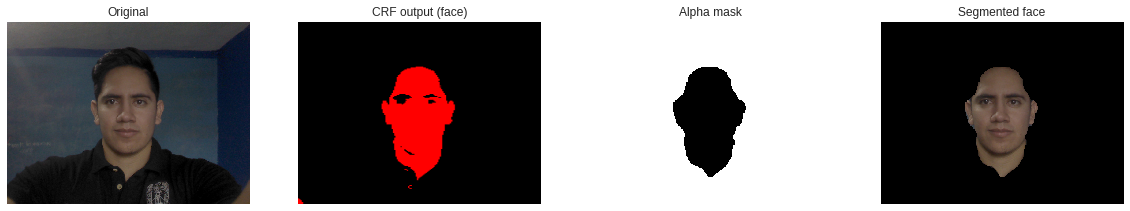

In [0]:
hair_mask, segmented_hair = matting(test_original, test_hair_trimap, test_original.shape)
face_mask, segmented_face = matting(test_original, test_face_trimap, test_original.shape)

plot_imgs([test_original, crf_test_hair ,hair_mask, segmented_hair], ["Original",  "CRF output (hair)", "Alpha mask", "Segmented hair"], (20, 20))
plot_imgs([test_original, crf_test_face ,face_mask, segmented_face], ["Original",  "CRF output (face)", "Alpha mask", "Segmented face"], (20, 20))

## Inference using model and post-processing with CFR and image matting

### On images

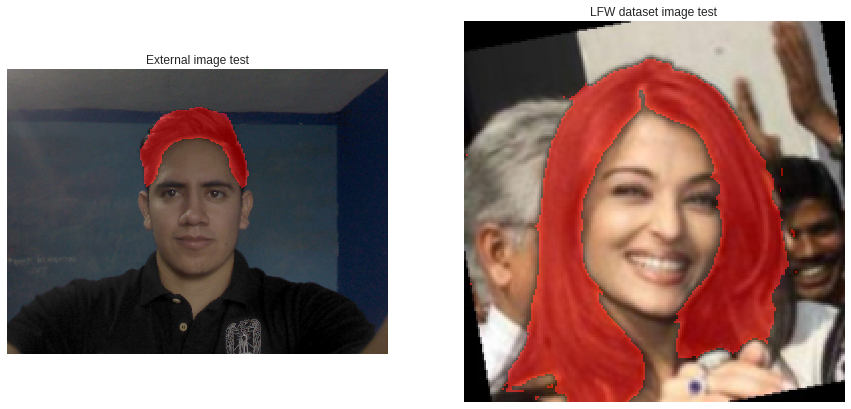

In [0]:
def paint(image, hair_mask, face_mask, color=(-130, 0, 0)):
  h, w, _ = image.shape
  
  for i in range(h):
    for j in range(w):
      temp = image[i, j]
      if hair_mask[i, j] != 0:
        image[i, j] = temp + color
      if face_mask[i, j] != 0:
        image[i, j] = temp
        
  return image
  

edited = np.copy(test_original)
edited_hs = np.copy(original)


edited = paint(edited, hair_mask, face_mask)
edited_hs = paint(edited_hs, hair_mask_ds, face_mask_ds)

plot_imgs([edited, edited_hs], ["External image test", "LFW dataset image test"], (15, 15))

### On video

In [0]:
import glob
import os 
import cv2

def get_frame_rate(video):
    video = cv2.VideoCapture(video);
    # Find OpenCV version
    (major_ver, minor_ver, subminor_ver) = (cv2.__version__).split('.')
    if int(major_ver)  < 3 :
        fps = video.get(cv2.cv.CV_CAP_PROP_FPS)
        print("Frames per second using video.get(cv2.cv.CV_CAP_PROP_FPS): {0}".format(int(fps)))
    else :
        fps = video.get(cv2.CAP_PROP_FPS)
        print("Frames per second using video.get(cv2.CAP_PROP_FPS) : {0}".format(int(fps)))
    video.release();
    return int(fps)
    
def process_video(video, path_to_save):
    cap = cv2.VideoCapture(video)
    print("Number of frames: ", int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
    ret, frame = cap.read()
    cont = 0
    
    while ret:
      if cont > 67:
        
        test_original_r = scipy.misc.imresize(frame, (192, 192))
        h, w, _ = frame.shape
        # Get model prediction
        test_input = test_original_r.reshape(1, 192, 192, 3).astype(float)
        test_probs_pred = model.predict(normalize(test_input)).reshape(192, 192, 3)
        test_pred = np.uint8((test_probs_pred.round())*255)
        test_pred_r = scipy.misc.imresize(test_pred, (h, w)) 
        
        # Apply CFR 
        crf_test_hair = CRF(test_original_r, test_pred, 0, 10, (2,2), 10, (50, 50), 10)
        crf_test_face = CRF(test_original_r, test_pred, 1, 5)
        crf_test_hair = scipy.misc.imresize(crf_test_hair, (h, w))
        crf_test_face = scipy.misc.imresize(crf_test_face, (h, w))

        # Generate trimap
        test_face_trimap = get_trimap(crf_test_face, size=30)[:,:,0]
        test_hair_trimap = get_trimap(crf_test_hair, size=20)[:,:,0]
        
        
        paint = True
        try: 
          hair_mask, segmented_hair = matting(frame, test_hair_trimap, frame.shape)
          face_mask, segmented_face = matting(frame, test_face_trimap, frame.shape)
            
        except:
          try: # If CFR didn't give results try using the model prediction
            test_hair_trimap = get_trimap(test_pred_r[:,:,0], size=20)
            test_face_trimap = get_trimap(test_pred_r[:,:,1], size=20)
            
            hair_mask, segmented_hair = matting(frame, test_hair_trimap, frame.shape)
            face_mask, segmented_face = matting(frame, test_face_trimap, frame.shape)
          except: # If model didn't give results return frame and avoid paint 
            paint = False
            test_face_trimap = frame
            test_hair_trimap = frame

        edited = np.copy(frame)

        if paint:
          for i in range(h):
            for j in range(w):
              temp = edited[i, j]
              if hair_mask[i, j] != 0:
                color = temp + (-130, 0, 0)
                edited[i, j] =  color
              if face_mask[i, j] != 0:
                edited[i, j] = temp

        cv2.imwrite(path_to_save + str(cont) + ".jpg", edited)
        
      cont += 1
      ret, frame = cap.read()
      
    print("Video processed.")

def make_video(outvid, images=None, fps=30, size=None, is_color=True, format="FMP4"):
    fourcc = cv2.VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.exists(image):
            raise FileNotFoundError(image)
        img = cv2.imread(image)
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = cv2.VideoWriter(outvid, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = cv2.resize(img, size)
        vid.write(img)
    vid.release()
    return vid
    
def detect_on_video(video, out_path, fps):
    # Process video to get all the frames with detections
    process_video(video, out_path)
    # Get processed frames and order by name
    images = list(glob.iglob(os.path.join(out_path, '*.jpg')))
    images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))
    # Create the video from processed frames
    make_video(out_path+"output.mp4", images, fps)
    print("Video: "+ out_path +" output.mp4 it's ready")

video = './images/3.mp4'
path = './video/'

fps = get_frame_rate(video)
detect_on_video(video, path, fps+1)

Frames per second using video.get(cv2.CAP_PROP_FPS) : 14
Video: ./video/ output.mp4 it's ready


![output]("images/hairsegmentation.gif")